# Machine Learning Recommendation System: Book Crossing Dataset

## À propos du dataset Book Crossing

Ce dataset a été compilé par Cai-Nicolas Ziegler en 2004 et comprend trois tables :

1. **Utilisateurs** : Informations sur les utilisateurs du système.
2. **Livres** : Détails sur les livres disponibles dans le système.
3. **Évaluations** : Les évaluations des livres par les utilisateurs, exprimées comme suit :
   - **Évaluations explicites** : Sur une échelle de 1 à 10, où les valeurs les plus élevées indiquent une plus grande appréciation.
   - **Évaluations implicites** : Exprimées par 0, indiquant qu'un utilisateur n'a pas évalué le livre.

## À propos de ce projet

Ce projet consiste à construire un **système de recommandation de livres** pour les utilisateurs basé sur des approches de **filtrage collaboratif** centrées sur :

- **L'utilisateur** : Recommandations basées sur les préférences d'un utilisateur similaire.
- **L'élément** : Recommandations basées sur la similarité entre les livres.

---

### Suggestions for Structuring Your Jupyter Notebook

1. **Title Section**: Include the title of the project at the top with your name and date.
   
2. **Introduction**:
   - Briefly describe the goal of the project.
   - Provide a summary of the dataset and its relevance.

3. **Data Overview**:
   - Include a section for data exploration, summarizing the three tables.
   - Use visualizations (like histograms or bar charts) to illustrate the distribution of ratings.

4. **Methodology**:
   - Detail the collaborative filtering approaches you plan to implement.
   - Explain any algorithms or techniques you will use (e.g., matrix factorization, nearest neighbors).

5. **Implementation**:
   - Code snippets demonstrating data preprocessing, model training, and evaluation.
   - Ensure to comment your code for clarity.

6. **Results**:
   - Present the outcomes of your recommendation system.
   - Use visualizations to show recommendations for users or performance metrics.

7. **Conclusion**:
   - Summarize the findings and potential improvements for future work.

8. **References**:
   - Include any references used in your research or project.


## Importation des bibliothèques pour le système de recommandation de livres

In [19]:
# Importing Required Libraries

# Allowing multiple loading of the KMP library (for certain environments)
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Data Manipulation Libraries
import pandas as pd
import numpy as np

import pickle

# Import necessary functions from Fast.ai
from fastai.collab import CollabDataLoaders, collab_learner
from fastai import *
from fastai.tabular.all import *


# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from annoy import AnnoyIndex



In [2]:
# Load the Ratings Dataset

# Load the dataset from a CSV file
ratings = pd.read_csv('./Dataset/BX-Book-Ratings.csv', delimiter=";", encoding="latin1")

# Rename the columns for easier access
ratings.columns = ['userId', 'ISBN', 'bookRating']

# Display the first few rows of the ratings dataset
ratings.head()


,userId,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [3]:
# Load the Users Dataset

# Load the dataset from a CSV file
users = pd.read_csv('./Dataset/BX-Users.csv', delimiter=";", encoding="latin1")

# Rename the columns for easier access
users.columns = ['userId', 'location', 'age']

# Display the first few rows of the users dataset
users.head()


,userId,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [4]:
# Load the Books Dataset

# Load the dataset from a CSV file
books = pd.read_csv('./Dataset/BX-Books.csv', delimiter=";", encoding="latin-1", on_bad_lines='skip')

# Rename the columns for easier access
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageURLS', 'imageURLM', 'imageURLL']

# Display the first few rows of the books dataset
books.head()


C:\Users\asus\AppData\Local\Temp\ipykernel_15208\2910278570.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('./Dataset/BX-Books.csv', delimiter=";", encoding="latin-1", on_bad_lines='skip')


,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageURLS,imageURLM,imageURLL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [5]:
print(books.info())
print(books.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ISBN               271360 non-null  object
 1   bookTitle          271360 non-null  object
 2   bookAuthor         271358 non-null  object
 3   yearOfPublication  271360 non-null  object
 4   publisher          271358 non-null  object
 5   imageURLS          271360 non-null  object
 6   imageURLM          271360 non-null  object
 7   imageURLL          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None
ISBN                 0
bookTitle            0
bookAuthor           2
yearOfPublication    0
publisher            2
imageURLS            0
imageURLM            0
imageURLL            3
dtype: int64


In [6]:
print(ratings.shape)
print(users.shape)
print(books.shape)


(1149780, 3)
(278858, 3)
(271360, 8)


In [7]:
# Dropping Unnecessary Image Columns

# Drop the image URL columns from the books DataFrame
books.drop(['imageURLS', 'imageURLM', 'imageURLL'], axis=1, inplace=True)

# Display the first few rows of the updated books dataset
books.head()


,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


# **DATA WRANGLING**

In [8]:
# Check the data types of the ratings DataFrame
print("Ratings Data Types:")
print(ratings.dtypes)

# Check unique book ratings
print("\nUnique Book Ratings:")
print(ratings['bookRating'].unique())

# Check the data types of the users DataFrame
print("\nUsers Data Types:")
print(users.dtypes)

# Check the data types of the books DataFrame
print("\nBooks Data Types:")
print(books.dtypes)

# Check unique years of publication in the books DataFrame
print("\nUnique Years of Publication:")
print(books['yearOfPublication'].unique())


Ratings Data Types:
userId         int64
ISBN          object
bookRating     int64
dtype: object

Unique Book Ratings:
[ 0  5  3  6  8  7 10  9  4  1  2]

Users Data Types:
userId        int64
location     object
age         float64
dtype: object

Books Data Types:
ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
dtype: object

Unique Years of Publication:
[2002 2001 1991 1999 2000 1993 1996 1988 2004 1998 1994 2003 1997 1983
 1979 1995 1982 1985 1992 1986 1978 1980 1952 1987 1990 1981 1989 1984 0
 1968 1961 1958 1974 1976 1971 1977 1975 1965 1941 1970 1962 1973 1972
 1960 1966 1920 1956 1959 1953 1951 1942 1963 1964 1969 1954 1950 1967
 2005 1957 1940 1937 1955 1946 1936 1930 2011 1925 1948 1943 1947 1945
 1923 2020 1939 1926 1938 2030 1911 1904 1949 1932 1928 1929 1927 1931
 1914 2050 1934 1910 1933 1902 1924 1921 1900 2038 2026 1944 1917 1901
 2010 1908 1906 1935 1806 2021 '2000' '1995' '1999'

# **DATA CLEANING**

In [9]:

# Check for invalid entries in the yearOfPublication column
invalid_years = books.loc[books['yearOfPublication'] == 'DK Publishing Inc', :]
print("Invalid Year Entries:")
print(invalid_years)

# Display entries with other invalid year values
print("\nOther Invalid Year Entries:")
print(books[books['yearOfPublication'].str.contains('Gallimard', na=False, case=False)])

# Display all rows where yearOfPublication is not numeric or has invalid values
print("\nRows with Non-Numeric Year Values:")
non_numeric_years = books[~books['yearOfPublication'].astype(str).str.isnumeric()]
print(non_numeric_years)


Invalid Year Entries:
              ISBN  \
209538  078946697X   
221678  0789466953   

                                                                                                          bookTitle  \
209538         DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\";Michael Teitelbaum"   
221678  DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\";James Buckley"   

       bookAuthor  yearOfPublication  \
209538       2000  DK Publishing Inc   
221678       2000  DK Publishing Inc   

                                                           publisher  
209538  http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg  
221678  http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg  

Other Invalid Year Entries:
              ISBN  \
220731  2070426769   

                                                                       bookTitle  \
220731  Peuple du ciel, suivi de 'Les Bergers\";Jean-Marie Gu

In [55]:
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"



In [56]:
books.loc[books.ISBN == '0789466953', 'yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953', 'bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953', 'publisher'] = "DK Publishing Inc"

In [57]:
books.loc[books.yearOfPublication == 'Gallimard']

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [58]:
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'
books.loc[books.ISBN == '2070426769','publisher'] = 'Gallimard'

In [59]:
books.yearOfPublication = pd.to_numeric(books.yearOfPublication)

In [60]:
sorted(books['yearOfPublication'].unique())

[0,
 1376,
 1378,
 1806,
 1897,
 1900,
 1901,
 1902,
 1904,
 1906,
 1908,
 1909,
 1910,
 1911,
 1914,
 1917,
 1919,
 1920,
 1921,
 1922,
 1923,
 1924,
 1925,
 1926,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1939,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2008,
 2010,
 2011,
 2012,
 2020,
 2021,
 2024,
 2026,
 2030,
 2037,
 2038,
 2050]

In [10]:
# **ANALYZING INVALID PUBLICATION YEARS**

# Identify books with yearOfPublication equal to 0
books_with_zero_year = books.loc[books['yearOfPublication'] == 0, :]
print("Books with Year of Publication == 0:")
print(books_with_zero_year)

# Identify books with yearOfPublication equal to 1376
books_with_invalid_year = books.loc[books['yearOfPublication'] == 1376, :]
print("\nBooks with Year of Publication == 1376:")
print(books_with_invalid_year)


Books with Year of Publication == 0:
              ISBN  \
176     3150000335   
188     342311360X   
288     0571197639   
351     3596214629   
542     8845229041   
...            ...   
270794  014029953X   
270913  0340571187   
271094  8427201079   
271182  0887781721   
271196  3150013763   

                                                           bookTitle  \
176                                                 Kabale Und Liebe   
188                                          Die Liebe in Den Zelten   
288                                      Poisonwood Bible Edition Uk   
351                     Herr Der Fliegen (Fiction, Poetry and Drama)   
542     Biblioteca Universale Rizzoli: Sulla Sponda Del Fiume Piedra   
...                                                              ...   
270794                                    Foe (Essential.penguin S.)   
270913                                                Postmens House   
271094                                      El Mis

# **MERGING DATAFRAMES**


In [11]:

# Merge the ratings DataFrame with the books DataFrame on the ISBN column
rating_book = pd.merge(ratings, books, on='ISBN')

# Display the first few rows of the merged DataFrame
print("Merged Ratings and Books DataFrame:")
print(rating_book.head())


Merged Ratings and Books DataFrame:
   userId        ISBN  bookRating  \
0  276725  034545104X           0   
1  276726  0155061224           5   
2  276727  0446520802           0   
3  276729  052165615X           3   
4  276729  0521795028           6   

                                                        bookTitle  \
0                                            Flesh Tones: A Novel   
1                                                Rites of Passage   
2                                                    The Notebook   
3                                                  Help!: Level 1   
4  The Amsterdam Connection : Level 4 (Cambridge English Readers)   

        bookAuthor yearOfPublication                   publisher  
0       M. J. Rose              2002            Ballantine Books  
1       Judith Rae              2001                      Heinle  
2  Nicholas Sparks              1996                Warner Books  
3    Philip Prowse              1999  Cambridge University

In [12]:
rating_book.head()

,userId,ISBN,bookRating,bookTitle,bookAuthor,yearOfPublication,publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge English Readers),Sue Leather,2001,Cambridge University Press


In [13]:
# **MERGING WITH USER DATA**

# Merge the rating_book DataFrame with the users DataFrame on userId
all_ratings = pd.merge(rating_book, users, on='userId')

# Display the merged DataFrame to check the new dataset
print("Merged Ratings, Books, and Users DataFrame:")
print(all_ratings.head())


Merged Ratings, Books, and Users DataFrame:
   userId        ISBN  bookRating  \
0  276725  034545104X           0   
1  276726  0155061224           5   
2  276727  0446520802           0   
3  276729  052165615X           3   
4  276729  0521795028           6   

                                                        bookTitle  \
0                                            Flesh Tones: A Novel   
1                                                Rites of Passage   
2                                                    The Notebook   
3                                                  Help!: Level 1   
4  The Amsterdam Connection : Level 4 (Cambridge English Readers)   

        bookAuthor yearOfPublication                   publisher  \
0       M. J. Rose              2002            Ballantine Books   
1       Judith Rae              2001                      Heinle   
2  Nicholas Sparks              1996                Warner Books   
3    Philip Prowse              1999  Cambridg

In [14]:
all_ratings

,userId,ISBN,bookRating,bookTitle,bookAuthor,yearOfPublication,publisher,location,age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,"tyler, texas, usa",NaN
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,"seattle, washington, usa",NaN
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,"h, new south wales, australia",16.0
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,"rijeka, n/a, croatia",16.0
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge English Readers),Sue Leather,2001,Cambridge University Press,"rijeka, n/a, croatia",16.0
...,...,...,...,...,...,...,...,...,...
1031131,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book of Life,Kevin J. Todeschi,1998,A.R.E. Press (Association of Research &amp; Enlig,"cedar park, texas, usa",NaN
1031132,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the Savvy Consumer,Clark Howard,2000,Longstreet Press,"cedar park, texas, usa",NaN
1031133,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Program for Taking Full Advantage of Your Body's Natural Healing Power (Proven Program for Taking Full Advantage of Your Body's Natural Healing Power),Andrew Weil,1997,Alfred A. Knopf,"quebec, quebec, canada",18.0
1031134,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,"mannington, west virginia, usa",38.0


# **VISUALIZING DATA SPARSITY AND SEGREGATING RATINGS**

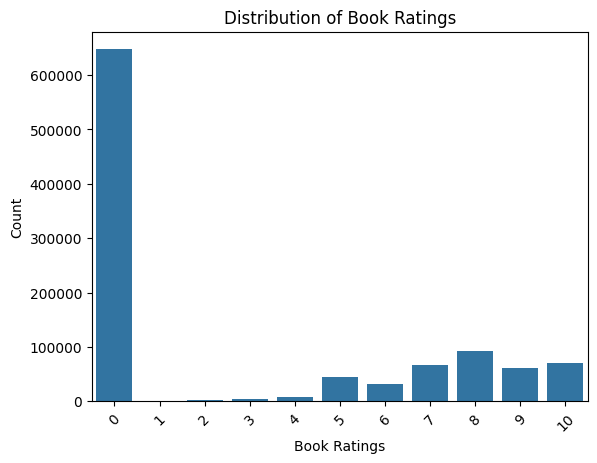

Size of Explicit Ratings Dataset: (383842, 9)
Size of Implicit Ratings Dataset: (647294, 9)


In [15]:
# Count the number of explicit and implicit ratings
ratings_count = all_ratings['bookRating'].value_counts()
sns.barplot(x=ratings_count.index, y=ratings_count.values)
plt.title('Distribution of Book Ratings')
plt.xlabel('Book Ratings')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# **Segregating explicit and implicit ratings datasets**
ratings_explicit = all_ratings[all_ratings['bookRating'] != 0]
ratings_implicit = all_ratings[all_ratings['bookRating'] == 0]

# Display the size of the new datasets
print("Size of Explicit Ratings Dataset:", ratings_explicit.shape)
print("Size of Implicit Ratings Dataset:", ratings_implicit.shape)


# **LOADING FAST.AI AND CREATING COLLABORATIVE DATALOADERS**


In [16]:
# Drop NaN values in 'bookRating' and 'bookTitle' for cleaner data
all_ratings = all_ratings.dropna(subset=['bookRating', 'bookTitle'])

# Ensure 'bookRating' is numeric (some might have been loaded as strings)
all_ratings['bookRating'] = pd.to_numeric(all_ratings['bookRating'], errors='coerce')

# Import necessary Fast.ai modules
from fastai.collab import *

# Create a CollabDataLoader using the cleaned all_ratings DataFrame
data = CollabDataLoaders.from_df(all_ratings, 
                                   seed=42, 
                                   valid_pct=0.1, 
                                   user_name='userId', 
                                   item_name='ISBN', 
                                   rating_name='bookRating')

# Preview the DataLoader
print("Preview of the DataLoader:")
data.show_batch()

Preview of the DataLoader:


,userId,ISBN,bookRating
0,186032,076790396X,5
1,238735,0064408620,8
2,198711,038529929X,0
3,229011,0440211484,6
4,245827,0517702835,0
5,162155,0821759442,0
6,138898,0321049314,0
7,238557,0345351525,0
8,198711,0816730253,0
9,102647,055358085X,0


# **CREATING A COLLAB_LEARNER**

In [52]:
# Create a CollabLearner
learn = collab_learner(data, n_factors=20, y_range=(0., 10.0), wd=1e-1)

C:\Users\asus\anaconda3\envs\en2\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_

SuggestedLRs(valley=0.17378008365631104)

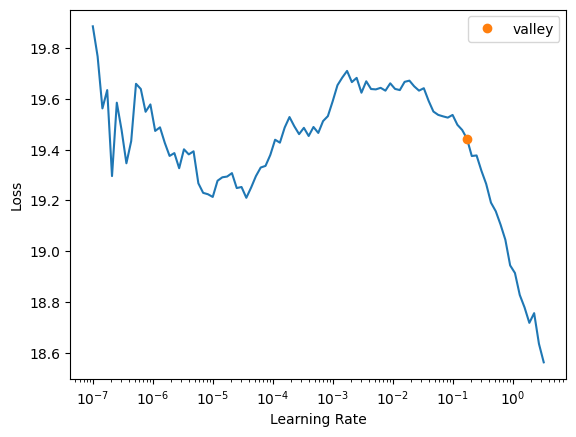

In [53]:
# Finding the optimal learning rate
learn.lr_find()

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

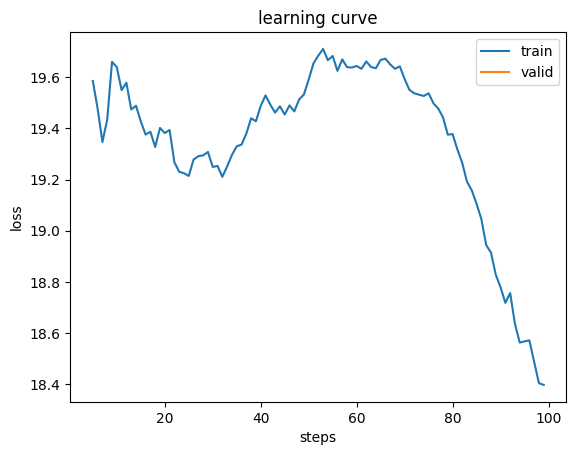

In [54]:
# Plotting the loss to visualize the learning rate
learn.recorder.plot_loss()

# **TRAINING THE MODEL**

In [55]:
# Fit the model using the chosen learning rate
learn.fit_one_cycle(10, 0.17378008365631104)

epoch,train_loss,valid_loss,time
0,14.332728,14.385139,02:32
1,14.933424,15.160814,02:34
2,14.971286,15.154833,02:36
3,14.933825,15.109237,01:54
4,15.015147,15.031466,02:25
5,14.697900,14.734993,02:11
6,14.014921,14.298814,01:36
7,13.663280,13.824518,01:37
8,12.907281,13.460971,01:49
9,12.521990,13.199234,01:47


# **VALIDATING THE MODEL**

In [56]:
# Validate the model to assess its performance on the validation set
validation_results = learn.validate()
print(f'Validation Loss: {validation_results[0]}, RMSE: {validation_results[1]}')

(#1) [13.199234008789062]

# **SAVING THE MODEL**

In [57]:
# Save the trained model for future use
learn.save('book_recommendation_model')

Path('models/book_recommendation_model.pth')

In [76]:
# **FUNCTION: SAVE PREPROCESSED DATA**
def save_preprocessed_data(all_ratings, filename='preprocessed_data.csv'):
    all_ratings.to_csv(filename, index=False)
    print(f"Données prétraitées sauvegardées dans {filename}")

# **FUNCTION: SAVE DATALOADER**
def save_dataloader(data, filename='dataloader.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"DataLoader sauvegardé dans {filename}")

# **FUNCTION: LOAD PREPROCESSED DATA**
def load_preprocessed_data(filename='preprocessed_data.csv'):
    return pd.read_csv(filename)

# **FUNCTION: LOAD DATALOADER**
def load_dataloader(filename='dataloader.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)



# **USAGE: SAVE DATA**
save_preprocessed_data(all_ratings)
save_dataloader(data)

# **FUNCTION: LOAD DATA AND DATALOADER**
def load_data_and_dataloader():
    all_ratings = load_preprocessed_data()
    data = load_dataloader()
    return all_ratings, data

# **EXAMPLE OF USAGE: LOAD DATA AND DATALOADER**
all_ratings_, data_ = load_data_and_dataloader()

Données prétraitées sauvegardées dans preprocessed_data.csv
DataLoader sauvegardé dans dataloader.pkl


In [77]:
# Recréer l'objet Learner avec les données
learn_ = collab_learner(data_, n_factors=20, y_range=(0., 10.0), wd=1e-1)

# **LOAD THE MODEL**
learn_.load('book_recommendation_model')

C:\Users\asus\anaconda3\envs\en2\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_

In [78]:
def recommend_books(user_id, n_recommendations=10):
    # Obtenir tous les ISBN uniques
    books = all_ratings_['ISBN'].unique()
    
    # Obtenir les livres que l'utilisateur n'a pas encore notés
    rated_books = all_ratings_[all_ratings['userId'] == user_id]['ISBN']
    unrated_books = list(set(books) - set(rated_books))
    
    # Créer un DataFrame pour les prédictions
    to_predict = pd.DataFrame({
        'userId': [user_id] * len(unrated_books),
        'ISBN': unrated_books
    })
    
    # Créer un DataLoader pour les prédictions
    dl = learn_.dls.test_dl(to_predict)
    
    # Obtenir les prédictions
    preds, _ = learn_.get_preds(dl=dl)
    
    # Convertir les prédictions en une liste de tuples (ISBN, prédiction)
    predicted_ratings = list(zip(unrated_books, preds.squeeze().tolist()))
    
    # Trier par note prédite
    recommendations = sorted(predicted_ratings, key=lambda x: x[1], reverse=True)
    
    return recommendations[:n_recommendations]

# **GET TOP BOOK RECOMMENDATIONS**
# Obtenir les 10 meilleures recommandations de livres pour l'utilisateur 93550
top_books = recommend_books(93550, 10)
print(top_books)

[('0439139597', 6.14607048034668), ('0446310786', 5.684464454650879), ('1844262553', 5.673132419586182), ('043935806X', 5.664853096008301), ('059035342X', 5.658758163452148), ('0812550706', 5.636228561401367), ('0590353403', 5.605792999267578), ('0440219078', 5.6015448570251465), ('0439136350', 5.564293384552002), ('0345339681', 5.550124645233154)]


# **FUNCTION: PREPROCESS DATA**

In [72]:
def preprocess_data(df):
    df.fillna({
        'bookTitle': 'Unknown',
        'bookAuthor': 'Unknown',
        'publisher': 'Unknown'
    }, inplace=True)
    df['features'] = df['bookTitle'] + " " + df['bookAuthor'] + " " + df['publisher']
    return df

# **FUNCTION: CREATE TF-IDF MATRIX**
def create_tfidf_matrix(df, max_features=10000):
    tfidf = TfidfVectorizer(stop_words='english', max_features=max_features)
    return tfidf.fit_transform(df['features']), tfidf

# **FUNCTION: BUILD ANNOY INDEX**
def build_annoy_index(tfidf_matrix, n_trees=10):
    dim = tfidf_matrix.shape[1]  # Dimension of each TF-IDF vector
    annoy_index = AnnoyIndex(dim, 'angular')  # Using angular distance (similar to cosine)
    for i in range(tfidf_matrix.shape[0]):
        annoy_index.add_item(i, tfidf_matrix[i].toarray()[0])  # Add the TF-IDF vectors to the index
    annoy_index.build(n_trees)  # Build the index with n trees
    return annoy_index

# **FUNCTION: RECOMMEND SIMILAR BOOKS**
def recommend_similar_books_annoy(isbn, df, annoy_index, n=5):
    try:
        idx = df[df['ISBN'] == isbn].index[0]  # Find the index of the book by ISBN
        book_indices = annoy_index.get_nns_by_item(idx, n+1)[1:]  # Get the n nearest neighbors (excluding the book itself)
        return df.iloc[book_indices][['ISBN', 'bookTitle', 'bookAuthor', 'publisher']].to_dict(orient='records')
    except IndexError:
        return "ISBN not found in dataset."

# **FUNCTION: SAVE ANNOY INDEX**
def save_annoy_index(annoy_index, file_path):
    annoy_index.save(file_path)

# **FUNCTION: SAVE TF-IDF VECTORIZER**
def save_tfidf_vectorizer(tfidf_vectorizer, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(tfidf_vectorizer, file)


In [ ]:
# **PREPROCESS THE DATA**
books_ = preprocess_data(books)

# **CREATE TF-IDF MATRIX**
tfidf_matrix, tfidf_vectorizer = create_tfidf_matrix(books_)

# **BUILD ANNOY INDEX**
annoy_index = build_annoy_index(tfidf_matrix)

# **SAVE ANNOY INDEX AND TF-IDF VECTORIZER FOR LATER USE**

In [ ]:
save_annoy_index(annoy_index, 'annoy_index.ann')
books_.to_csv("books_data.csv", index=False)
save_tfidf_vectorizer(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# **RECOMMEND BOOKS BASED ON AN ISBN**

In [ ]:
# **RECOMMEND BOOKS BASED ON AN ISBN**
isbn = "0312195516"  # Replace with the ISBN of your reference book
similar_books = recommend_similar_books_annoy(isbn, books_, annoy_index, n=5)

# **DISPLAY RECOMMENDED BOOKS**
print(f"Books similar to ISBN {isbn}:")
for book in similar_books:
    print(book)